##  Bayesian CNN with dropout-at-test-time

In [37]:
from matplotlib import pyplot as plt
import numpy as np

import json
import os, sys
from os.path import join, exists

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from config import DATA_PATH

plt.rcdefaults() 
%matplotlib inline

In [67]:
CLASSIFIERS = ["cnn/relu/featsqueeze3", #Feature Squeezing
               "cnn/relu/labsmooth", # Label Smoothing
               #"cnn/relu/adv-trained/fgsm/eps0.30_train.npy", # Adversarial training FGSM eps=0.4
               #"cnn/relu/adv-trained/vat/eps2.10_train.npy",  # Adversarial Training VAT eps=2.1
               "cnn/brelu/gaussian/stdev0.05/pert-insts10", # Gaussian sigma =0.3 + brelu
               "cnn/relu/gaussian/stdev0.05/pert-insts10",  # Gaussian sigma =0.3 + relu
               "cnn/relu", # vanilla cnn-relu
               "cnn/brelu"]
INPUT_PATH = join(DATA_PATH, 'classifiers','cifar10')
for c in CLASSIFIERS:
    assert exists(join(INPUT_PATH, c, "best-weights.h5"))
    assert exists(join(INPUT_PATH, c, "model.json"))
    assert exists(join(INPUT_PATH, c, "params.json"))

In [68]:
eps_values = [e/10 for e in range(1, 11)]
PATH = "/dccstor/dlw/data/adversarial_learning/adversarial/cifar10/"
for c in CLASSIFIERS:
    print(c)
    for eps in eps_values:
        assert exists(join(PATH, c, "fgsm", "eps%.2f_test.npy" % eps))



cnn/relu/featsqueeze3
cnn/relu/labsmooth
cnn/brelu/gaussian/stdev0.05/pert-insts10
cnn/relu/gaussian/stdev0.05/pert-insts10
cnn/relu
cnn/brelu


In [40]:
from src.classifiers.bnn import BNN
from src.utils import load_cifar10
import keras.backend as K
import tensorflow as tf

#important for ensuring the model_weights are loaded in the same session as the one where metrics are computed
session = tf.Session()
K.set_session(session)

In [41]:
(_,_), (X_test, Y_test),_,_ = load_cifar10() 

## Mutual Information

In [42]:
def mutual_inf(MC_samples):
    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    return entropy_expected_p - expected_entropy

In [48]:
mean_mutual_info = {}
for c in CLASSIFIERS:
    classifier = BNN._load_from_cnn(file_path=join(INPUT_PATH, c),weights_name='best-weights.h5',nb_mc_samples=100)
    samples = classifier._mc_preds(X_test)
    mean_mutual_info[c] = [np.mean(mutual_inf(samples))]
    for eps in eps_values:
        adv_test = np.load(join(PATH, c, "fgsm", "eps%.2f_test.npy" % eps))
        samples = classifier._mc_preds(adv_test)
        mean_mutual_info[c].append(np.mean(mutual_inf(samples)))
        
np.save('mean_mutual_info.npy',mean_mutual_info)

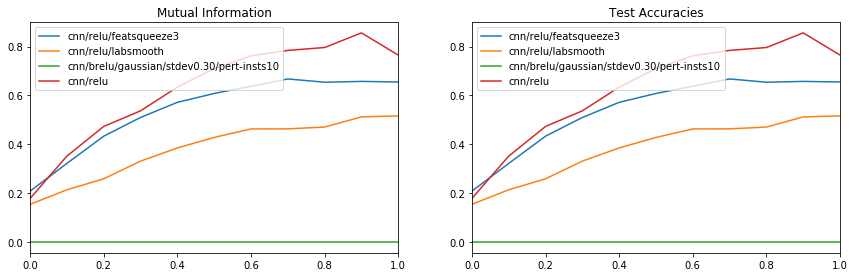

In [50]:
mean_mutual_info = np.load('mean_mutual_info.npy')[()]
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.title("Mutual Information")

for c in CLASSIFIERS:
    plt.plot([0.] + eps_values, mean_mutual_info[c], label=c)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.legend()

ax = fig.add_subplot(1, 2, 2)
plt.title("Test Accuracies")

for c in CLASSIFIERS:
    plt.plot([0.] + eps_values, mean_mutual_info[c], label=c)
    
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
    
plt.subplots_adjust(bottom=0.1, right=2, top=0.9)
plt.legend()